In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
import os
%matplotlib inline
np.random.seed(1)

### 1. Load Data Functions

In [2]:
def convert_to_onehot(X, num_classes):
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

In [3]:
def load_data():
    num_classes = 40
    rootDir = '/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/Face_dataset/orl_faces'
    X=[]
    y=[]
    label = 0
    flag = 0
    basedir = ""
    for dirName, subdirList, fileList in os.walk(rootDir):
        if flag ==0:
            basedir = dirName
            flag =1
        else:
            for fname in fileList:
                img = Image.open( dirName+'/'+fname )
                data = np.array( img, dtype='uint8' )
                X.append(data)
                y.append(label)
            label = label +1
            
    #Shuffle Data
    arr = np.random.permutation(400)
    X=np.array(X)
    y=np.array(y)
    X = np.take(X,arr,axis=0)
    y = np.take(y,arr,axis=0)
    
    #split Data in train and test
    X_test = X[0:80]
    y_test = y[0:80]
    X_train = X[80:400]
    y_train = y[80:400]
#     print(y_test)
    y_train = convert_to_onehot(y_train, num_classes)
    y_test = convert_to_onehot(y_test, num_classes)
    return X_test,y_test, X_train,y_train
    

In [4]:
def load_outlier_data():
    num_classes = 40
    rootDir = '/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/OutlierTestData/At&tFace'
    X=[]
    flag = 0
    basedir = ""
    
    for dirName, subdirList, fileList in os.walk(rootDir):
        for fname in fileList:
            img = Image.open( dirName+'/'+fname )
            data = np.array( img, dtype='uint8' )
            X.append(data)
    
    return X

In [5]:
X_test,y_test,X_train,y_train = load_data()
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]


In [6]:
X_outlier = load_outlier_data()
X_outlier = np.array(X_outlier)
X_outlier = X_outlier.transpose(0,2,1,3)
X_outlier = X_outlier[:,:,:,0][:,:,:,np.newaxis]
print("X_outlier shape: "+ str(X_outlier.shape))

X_outlier shape: (10, 112, 92, 1)


### 2. Dimension Check

In [7]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
# plt.imshow(X[img])

# print(y_test[0])

(80, 112, 92, 1)
(320, 112, 92, 1)
(80, 40)
(320, 40)


In [8]:
from sys import getsizeof
X_train.nbytes

3297280

### 3 -  Tensorflow Forward Pass


In [9]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters


In [10]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation


In [11]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    

    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')

    A1 = tf.nn.relu(Z1)

    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')

    A2 = tf.nn.relu(Z2)

    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')

    P2 = tf.contrib.layers.flatten(P2)

    Z3 = tf.contrib.layers.fully_connected(P2, 40, activation_fn=None)

    return Z3

### 6 - Compute Cost

In [12]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [13]:
def get_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    sample = np.random.randint(low=0, high=m, size=m)
    shuffled_X = X[sample]
    shuffled_Y = Y[sample]
    
    for k in range(0, int(m/mini_batch_size)):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:
import time
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 150, minibatch_size = 20, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0,n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    saver=tf.train.Saver()
    with tf.Session() as sess:
        tr_start_time = time.time()
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = get_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        save_path = saver.save(sess, "/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/trained_models/FACE/face.ckpt")
        print("Model saved in path: %s" % save_path)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        tr_end_time = time.time()
        
        te_start_time = time.time()
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        te_end_time = time.time()
        print("Training Time: "+ str(tr_end_time - tr_start_time) + " sec")
        print("Train Accuracy:", train_accuracy)
        print("Testing Time: "+ str(te_end_time - te_start_time) + " sec")
        print("Test Accuracy:", test_accuracy)
        outlier_predictions = predict_op.eval(feed_dict={X: X_outlier})
                
        return outlier_predictions,train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy

In [15]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    outlier_predictions,_, _, parameters = f(*args)
    toc = time.time()
    return outlier_predictions,toc - tic

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 65.001247
Cost after epoch 5: 3.400461
Cost after epoch 10: 0.426581
Cost after epoch 15: 0.017521
Cost after epoch 20: 0.005349
Cost after epoch 25: 0.003227
Cost after epoch 30: 0.002739
Cost after epoch 35: 0.001818
Cost after epoch 40: 0.001359
Cost after epoch 45: 0.001308
Cost after epoch 50: 0.001069
Cost after epoch 55: 0.000771
Cost after epoch 60: 0.00

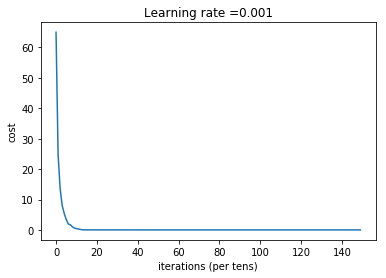

Training Time: 290.1019814014435 sec
Train Accuracy: 1.0
Testing Time: 0.23911690711975098 sec
Test Accuracy: 0.7625


In [16]:
outlier_predictions,execution_time = time_function(model, X_train, y_train, X_test, y_test)

In [17]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 295.4846498966217 sec


### 9. Outlier Test


In [18]:
samples_per_class = 40
num_classes = 1
# for i in range(10):
#     plt_idx = i+1
#     plt.subplot(samples_per_class, num_classes, plt_idx)  
#     plt.imshow(X_outlier[i].astype('uint8'))
#     plt.axis('off')
#     i = i+1
# plt.show()

for x in np.nditer(outlier_predictions):
    print(x)

2
12
2
2
2
22
6
11
2
25
